In [47]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from hessian_utils import *
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 
import time
import copy


# PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
# How to do this?
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
%matplotlib inline


In [48]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [49]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
train_X = cifar_trainset.data
train_y = cifar_trainset.targets
test_X = cifar_testset.data
test_y = cifar_testset.targets

In [51]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(16*8*8, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*8*8)
        x = self.linear(x)
        return x

In [52]:
train_X = torch.tensor(train_X).permute(0, 3, 1, 2).float()
test_X = torch.tensor(test_X).permute(0, 3, 1, 2).float()
train_X = (train_X / 255.0).to(device)
test_X = (test_X / 255.0).to(device)
train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
test_y = torch.tensor(test_y, dtype=torch.int64).to(device)
val_x = train_X[:1000]
val_y = train_y[:1000]
x_samples = train_X[:50]
y_samples = train_y[:50]

In [ ]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X[:1000], train_y[:1000]),
    batch_size=32, shuffle=True)

hessian_loader = []
for i, (x, y) in enumerate(dataloader):
    hessian_loader.append((x.to(device), y.to(device)))
    
model_SGD = Net().to(device)
model_Adam = copy.deepcopy(model_SGD)
model_Domke = copy.deepcopy(model_SGD)
criterion = nn.CrossEntropyLoss()
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=0.001)
optimizer_Adam = torch.optim.Adam(model_Adam.parameters(), lr=0.001)
# Optimizer for using dominant k eigenvalues of the hessian as a preconditioner.
optimizer_Domke = torch.optim.SGD(model_Domke.parameters(), lr=1)

In [54]:
# Training
train_losses_SGD = []
train_losses_Adam = []
train_losses_Domke = []
epochs = 10
for epoch in range(epochs):
    model_SGD.train()
    model_Adam.train()
    model_Domke.train()
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer_SGD.zero_grad()
        optimizer_Adam.zero_grad()
        optimizer_Domke.zero_grad()
        y_pred_SGD = model_SGD(x_batch)
        y_pred_Adam = model_Adam(x_batch)
        y_pred_Domke = model_Domke(x_batch)
        loss_SGD = criterion(y_pred_SGD, y_batch)
        loss_Adam = criterion(y_pred_Adam, y_batch)
        loss_Domke = criterion(y_pred_Domke, y_batch)
        train_losses_SGD.append(loss_SGD.item())
        train_losses_Adam.append(loss_Adam.item())
        train_losses_Domke.append(loss_Domke.item())
        loss_SGD.backward()
        loss_Adam.backward()
        loss_Domke.backward()
        optimizer_SGD.step()
        optimizer_Adam.step()
        with torch.enable_grad():
            x_batch.requires_grad_(True)
            hess = hessian(model_Domke, criterion, data=(x_batch, y_batch), cuda=False)
            eigvals, eigvecs = hess.eigenvalues(top_n=10)
            # Update each parameter's gradient using the eigenvalue preconditioner
            for param in model_Domke.parameters():
                if param.grad is not None:
                    grad = param.grad.view(-1)
                    precond_grad = torch.zeros_like(grad)
                    for i, vec in enumerate(eigvecs):
                        vec_flat = vec.view(-1)
                        # Avoid division by zero if any eigenvalue is very small
                        inv_eig = 1.0 / (eigvals[i] + 1e-12)
                        precond_grad += inv_eig * torch.dot(vec_flat, grad) * vec_flat
                    param.grad.copy_(precond_grad.view_as(param.grad))
            optimizer_Domke.step()
        print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(dataloader)}, Loss_SGD: {loss_SGD.item()}, Loss_Adam: {loss_Adam.item()}, Loss_Domke: {loss_Domke.item()}")

    print(f"Epoch {epoch+1}/{epochs}, Loss_SGD: {loss_SGD.item()}, Loss_Adam: {loss_Adam.item()}, Loss_Domke: {loss_Domke.item()}")

Epoch 1/10, Batch 1/32, Loss_SGD: 2.295377492904663, Loss_Adam: 2.295377492904663, Loss_Domke: 2.295377492904663
Epoch 1/10, Batch 2/32, Loss_SGD: 2.3400001525878906, Loss_Adam: 2.3382346630096436, Loss_Domke: 2.339996576309204
Epoch 1/10, Batch 3/32, Loss_SGD: 2.3172719478607178, Loss_Adam: 2.3224799633026123, Loss_Domke: 2.317260980606079
Epoch 1/10, Batch 4/32, Loss_SGD: 2.3138937950134277, Loss_Adam: 2.311293363571167, Loss_Domke: 2.3138957023620605
Epoch 1/10, Batch 5/32, Loss_SGD: 2.321671724319458, Loss_Adam: 2.3078291416168213, Loss_Domke: 2.321711301803589
Epoch 1/10, Batch 6/32, Loss_SGD: 2.2969601154327393, Loss_Adam: 2.2949442863464355, Loss_Domke: 2.297003984451294
Epoch 1/10, Batch 7/32, Loss_SGD: 2.3182504177093506, Loss_Adam: 2.305968761444092, Loss_Domke: 2.3183114528656006
Epoch 1/10, Batch 8/32, Loss_SGD: 2.327392578125, Loss_Adam: 2.3011248111724854, Loss_Domke: 2.3274707794189453
Epoch 1/10, Batch 9/32, Loss_SGD: 2.326876163482666, Loss_Adam: 2.3227052688598633, Lo

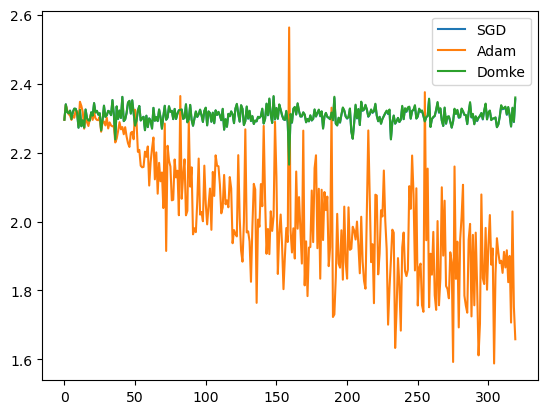

In [55]:
# Plotting the loss curves
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_Adam, label='Adam')
plt.plot(train_losses_Domke, label='Domke')
plt.legend()
plt.show()

In [56]:
# Saving the loss arrays
np.save('train_losses_SGD.npy', train_losses_SGD)
np.save('train_losses_Adam.npy', train_losses_Adam)
np.save('train_losses_Domke.npy', train_losses_Domke)